## What is Parallelization in LangGraph

In LangGraph, nodes typically execute in a sequence defined by edges, but when tasks don't depend on each other's outputs, you can run them in parallel. This is achieved by:
* Defining multiple nodes that can operate independently
* Connecting them to a common starting point (e.g. START or another node).
* Merging their outputs into a downstream node if needed.

LangGraph handles this implicitly when nodes are independent and can leverage multi-threading or asynchronous execution under the hood, depending on the runtime environment (e.g. Python's asyncio or a muilti-threaded executor).

In [1]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
load_dotenv()

os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")

llm = ChatGroq(model="openai/gpt-oss-120b")
llm.invoke("Hello")

AIMessage(content='Hello! How can I help you today?', additional_kwargs={'reasoning_content': 'The user says "Hello". We should respond friendly. No policy issues.'}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 72, 'total_tokens': 106, 'completion_time': 0.070473857, 'prompt_time': 0.002777487, 'queue_time': 0.046862553, 'total_time': 0.073251344, 'completion_tokens_details': {'reasoning_tokens': 16}}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_ff6aa7708c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--db69ed6c-c2ae-4911-a82c-9093a516d961-0', usage_metadata={'input_tokens': 72, 'output_tokens': 34, 'total_tokens': 106})

In [2]:
from pydantic import BaseModel
from typing import Optional

class State(BaseModel):
    topic: Optional[str] = None
    characters: Optional[str] = None
    settings: Optional[str] = None
    premises: Optional[str] = None
    story_intro: Optional[str] = None


In [3]:
# Creating the nodes
def generate_characters(state: State):
    """ Generate character descriptions"""
    msg = llm.invoke(f"Create two character names and brief traits for a story about {state.topic}")
    return {"characters": msg.content}

def generate_settings(state:State):
    """ Generate a story setting """
    msg = llm.invoke(f"Describe a vivid story about {state.topic}")
    return {"settings": msg.content}

def generate_premise(state: State):
    """ Generate a story premise """
    msg = llm.invoke(f"Write a one-sentence plot premise for a story about {state.topic}")
    return {"premises": msg.content}

def combine_elements(state: State):
    """ combine characters, settings and premise into an intro"""
    msg = llm.invoke(f"""
           Write a short story introduction using these elements.
           Characters: {state.characters}
           Setting: {state.settings}
           Premise: {state.premises}
""")
    return {"story_intro": msg.content}

In [4]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)

# add nodes
builder.add_node("character", generate_characters)
builder.add_node("setting", generate_settings)
builder.add_node("premise", generate_premise)
builder.add_node("combine", combine_elements)

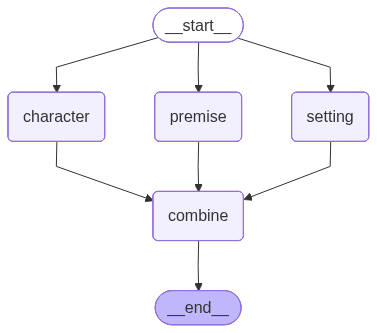

In [5]:
from IPython.display import Image, display

# add edges
builder.add_edge(START, "character")
builder.add_edge(START, "setting")
builder.add_edge(START, "premise")
builder.add_edge("character", "combine")
builder.add_edge("setting", "combine")
builder.add_edge("premise", "combine")
builder.add_edge("combine", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
state = State(topic="time travel")
result = graph.invoke(state)
result

{'topic': 'time travel',
 'characters': '**1. Dr. Selene Voss**\n\n- **Role:** Lead chronologist and inventor of the “Chrono‑Lattice”—a device that can open stable portals to specific moments in history.  \n- **Personality:** Brilliant, meticulous, and a little obsessive about timelines; she carries a pocket notebook where she logs every “what‑if” she encounters.  \n- **Quirks:** Speaks in rapid, half‑scientific bursts; always wears a silver locket that contains a tiny fragment of a future she’s trying to prevent.  \n- **Conflict:** Haunted by a personal loss she believes she can reverse, Selene wrestles with the ethical line between fixing history and playing god.\n\n---\n\n**2. Milo “Mick” Reyes**\n\n- **Role:** Street‑wise, quick‑thinking scavenger who becomes Selene’s reluctant field partner after stumbling upon one of her prototype portals.  \n- **Personality:** Charismatic, sarcastic, and fiercely protective of his friends; he trusts his gut more than any textbook.  \n- **Quirks: